### Business Problem

Telecom Inc., an American telecomunications company, is competing with a an up-start company that has eaten into their majority market share in recent years. To re-gain their market share, Telecom Inc. must first address the issue of customer churn. Telecom Inc. needs a model to help them predict which of customers are likely to churn to they can intervene and save the accounts. They also want to know what factors contribute to churn so they can improve their service to prevent future churn.

To evaluate the preformance of their customer churn model, Telecom Inc. will use F1 score because the firm wants to  capture true positives but is also concerned about minimizing false negatives and false positives. False positives are costly because in cases where our model predicts a customer will churn, Telecom Inc. intends to intervene with customer support and discounts. Given the class imbalence (81%), F1 score does a better job evaluating the true performance of our model.

#### To-do
- Create a class that takes in a model and prints out it's F1 score and all previous F1 scores
- Address class imbalence with SMOTE. It’s important to generate the new samples only in the training set to ensure our model generalizes well to unseen data.

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier

#Import data
df = pd.read_csv("data/cleaned_data.csv",index_col=0)

#New imports for our Pipeline workflows
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

#### Select target and features

In [2]:
X = df.drop(columns=["churn","phone number"])
y = df['churn']

#### Train test split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#### Build a class to evaluate our models

In [ ]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

#### Build a dummy model

In [4]:
#Imports
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
from sklearn.dummy import DummyClassifier

In [5]:
#Build our dummy model
Dummy_model = DummyClassifier(strategy="constant",constant=1)
Dummy_model.fit(X=X_train,y=y_train)
Dummy_model_pred = Dummy_model.predict(X_train)

In [6]:
#define a function to score our model
def model_results(model,X_train,y_train):
    plot_confusion_matrix(estimator=model,X=X_train,y_true=y_train)
    plot_roc_curve(estimator=Dummy_model,X=X_train,y=y_train)
    print(f'Avg f1 score {np.mean(cross_val_score(estimator=Dummy_model,X=X_train,y=y_train,cv=5,scoring="f1"))}')
    print(f'f1 cross validation scores {cross_val_score(estimator=Dummy_model,X=X_train,y=y_train,cv=5,scoring="f1")}')

Avg f1 score 0.25439602366201125
f1 cross validation scores [0.25420561 0.25420561 0.25420561 0.25468165 0.25468165]


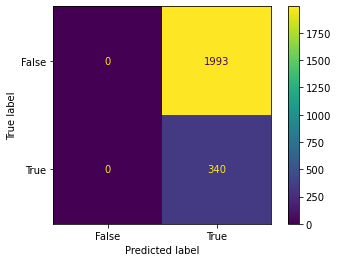

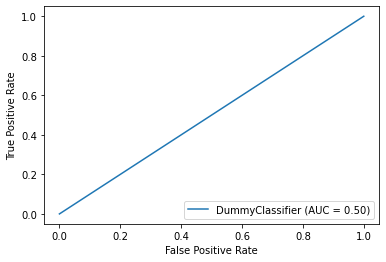

In [7]:
#Score our dummy model
model_results(model=Dummy_model,X_train=X_train,y_train=y_train)

### Build pipeline for Decision Tree 1.0

In [21]:
#Identify numeric columns for scaling
num_columns = list(df.select_dtypes(include=['float', 'int']).columns.drop('area code'))
#Instantiate column transformer
CT_ord = ColumnTransformer(transformers=[
    ("num_columns",StandardScaler(),num_columns),
    ("ohe",OneHotEncoder(sparse=False,handle_unknown="ignore"),["state","area code"]),    
    ("ord",OrdinalEncoder(),['international plan','voice mail plan'])
    ]
    )

In [22]:
#Instantiate a pipeline including the Decision Tree and one without the Decision Tree
#With Decision Tree
DT_Pipeline_ord = Pipeline([
    ("CT",CT_ord),
    ("estimator",DecisionTreeClassifier(random_state=42))
])
#Without Decision Tree, used for transforming
Pipeline_ord_trans = Pipeline([
    ("CT",CT_ord),
])

In [11]:
#Create grid search grid, instantiate grid search, and fit to train data
param_grid_pipeline = {'estimator__criterion':['gini','entropy'],'estimator__max_depth':[None,5,6,7,8],'estimator__min_samples_leaf':[1,5,10]}
GS_ord = GridSearchCV(estimator=DT_Pipeline_ord,param_grid=param_grid_pipeline,scoring="f1_weighted",cv=5)
GS_ord.fit(X=X_train,y=y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(transformers=[('num_columns',
                                                                         StandardScaler(),
                                                                         ['account '
                                                                          'length',
                                                                          'number '
                                                                          'vmail '
                                                                          'messages',
                                                                          'total '
                                                                          'day '
                                                                          'minutes',
                                                                          'total '
  

In [12]:
#To create a readible print of our feature importances we need to collate feature names from various places and pass into a dataframe
ohe_column_names = list(GS_ord.best_estimator_.named_steps.CT.named_transformers_.ohe.get_feature_names())
feature_names = num_columns
feature_names.extend(ohe_column_names)
feature_names.extend(['international plan','voice mail plan'])

In [13]:
#Put feature importance values into dataframe and sort values by feature importance
feature_importance_df = pd.DataFrame(data=GS_ord.best_estimator_.named_steps.estimator.feature_importances_,index=feature_names,columns=["feature importance"])
feature_importance_df.sort_values(by='feature importance',ascending=False).head(15)

,feature importance
customer service calls,0.149236
total day charge,0.149194
total day minutes,0.143441
total eve charge,0.134718
total intl calls,0.112925
international plan,0.110052
total intl minutes,0.076420
number vmail messages,0.073792
total eve calls,0.010577
total eve minutes,0.010348


In [14]:
print(f'Weighted avg f1 score: {round(GS_ord.best_score_,3)}')
print()
print(f'Split 1 f1 score: {round(GS_ord.cv_results_["split0_test_score"][GS_ord.best_index_],3)}')
print(f'Split 2 f1 score: {round(GS_ord.cv_results_["split1_test_score"][GS_ord.best_index_],3)}')
print(f'Split 3 f1 score: {round(GS_ord.cv_results_["split2_test_score"][GS_ord.best_index_],3)}')
print(f'Split 4 f1 score: {round(GS_ord.cv_results_["split3_test_score"][GS_ord.best_index_],3)}')
print(f'Split 5 f1 score: {round(GS_ord.cv_results_["split4_test_score"][GS_ord.best_index_],3)}')

Weighted avg f1 score: 0.938

Split 1 f1 score: 0.933
Split 2 f1 score: 0.927
Split 3 f1 score: 0.935
Split 4 f1 score: 0.943
Split 5 f1 score: 0.951
